In [2]:
import pandas as pd 
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import re

from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import brier_score_loss, mean_squared_error, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.calibration import calibration_curve

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [3]:
current_directory = os.getcwd()
print(current_directory)


c:\Users\tyler\OneDrive\Desktop\GSB_544


In [5]:
df = pd.read_csv("cimis_all_stations_clean.csv")  


In [6]:
df.head()

,Stn Id,Stn Name,CIMIS Region,Date,Hour (PST),Jul,ETo (mm),qc,Precip (mm),qc.1,Sol Rad (W/sq.m),qc.2,Vap Pres (kPa),qc.3,Air Temp (C),qc.4,Rel Hum (%),qc.5,Dew Point (C),qc.6,Wind Speed (m/s),qc.7,Wind Dir (0-360),qc.8,Soil Temp (C),qc.9
0,105,Westlands,San Joaquin Valley,9/28/2010,100,271,0.06,,0.0,,0.0,,0.9,,20.6,,35.0,,4.7,,1.7,,253.0,,22.8,
1,105,Westlands,San Joaquin Valley,9/28/2010,200,271,0.05,,0.0,,0.0,,0.9,,20.0,,38.0,,5.3,,1.8,,95.0,,22.5,
2,105,Westlands,San Joaquin Valley,9/28/2010,300,271,0.04,,0.0,,0.0,,0.9,,19.0,,42.0,,5.9,,1.3,,141.0,,22.2,
3,105,Westlands,San Joaquin Valley,9/28/2010,400,271,0.03,,0.0,,0.0,,0.9,,18.8,,41.0,,5.2,,1.0,,186.0,,21.9,
4,105,Westlands,San Joaquin Valley,9/28/2010,500,271,0.04,,0.0,,0.0,,0.7,,16.6,,40.0,,2.8,,1.4,,254.0,,21.6,


In [7]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Day'] = df['Date'].dt.day

In [8]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['Season'] = df['Month'].apply(get_season)

In [9]:
print(df[['Date', 'Month', 'Year', 'Season']].head())

        Date  Month  Year Season
0 2010-09-28      9  2010   Fall
1 2010-09-28      9  2010   Fall
2 2010-09-28      9  2010   Fall
3 2010-09-28      9  2010   Fall
4 2010-09-28      9  2010   Fall


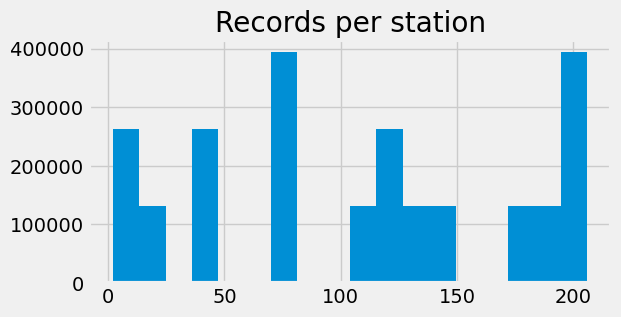

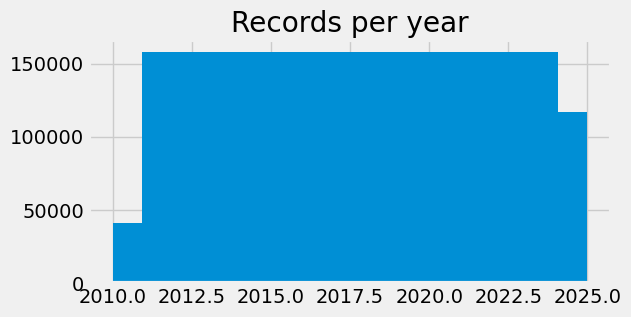

In [10]:
plt.figure(figsize=(6,3))
df["Stn Id"].hist(bins=df["Stn Id"].nunique())
plt.title("Records per station")
plt.show()

plt.figure(figsize=(6,3))
df["Year"].hist(bins=df["Year"].nunique())
plt.title("Records per year")
plt.show()

We can see above that some stations have more data than others, but this should not be an issue going forward as we will be implementing LOSO (Leave One Station Out) validation. Therefore we will evaluate our model leaving each of the 18 stations out, so this should not effect our outcome. 

In [11]:
df.columns

Index(['Stn Id', 'Stn Name', 'CIMIS Region', 'Date', 'Hour (PST)', 'Jul',
       'ETo (mm)', 'qc', 'Precip (mm)', 'qc.1', 'Sol Rad (W/sq.m)', 'qc.2',
       'Vap Pres (kPa)', 'qc.3', 'Air Temp (C)', 'qc.4', 'Rel Hum (%)', 'qc.5',
       'Dew Point (C)', 'qc.6', 'Wind Speed (m/s)', 'qc.7', 'Wind Dir (0-360)',
       'qc.8', 'Soil Temp (C)', 'qc.9', 'Month', 'Year', 'Day', 'Season'],
      dtype='object')

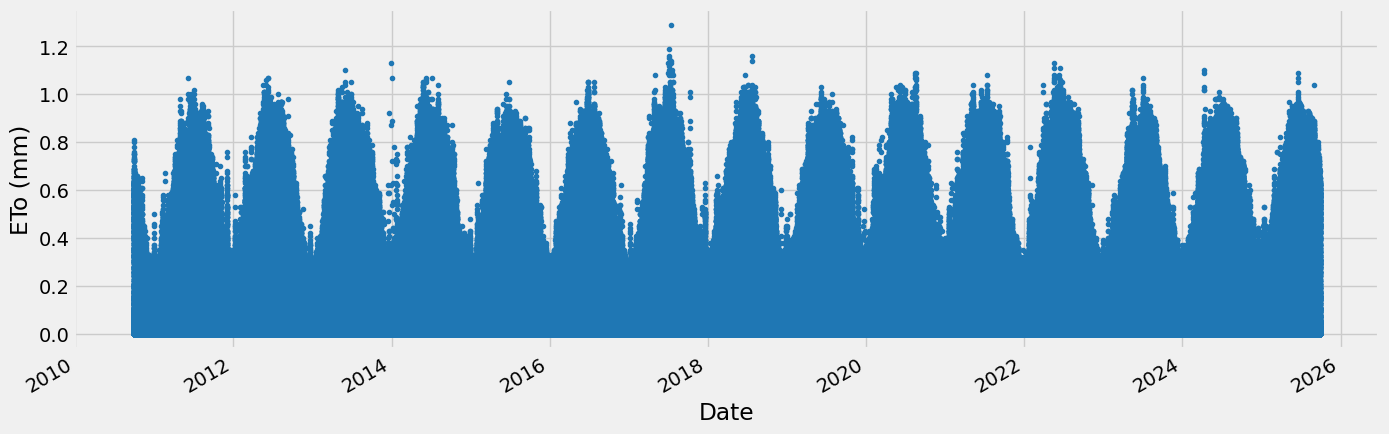

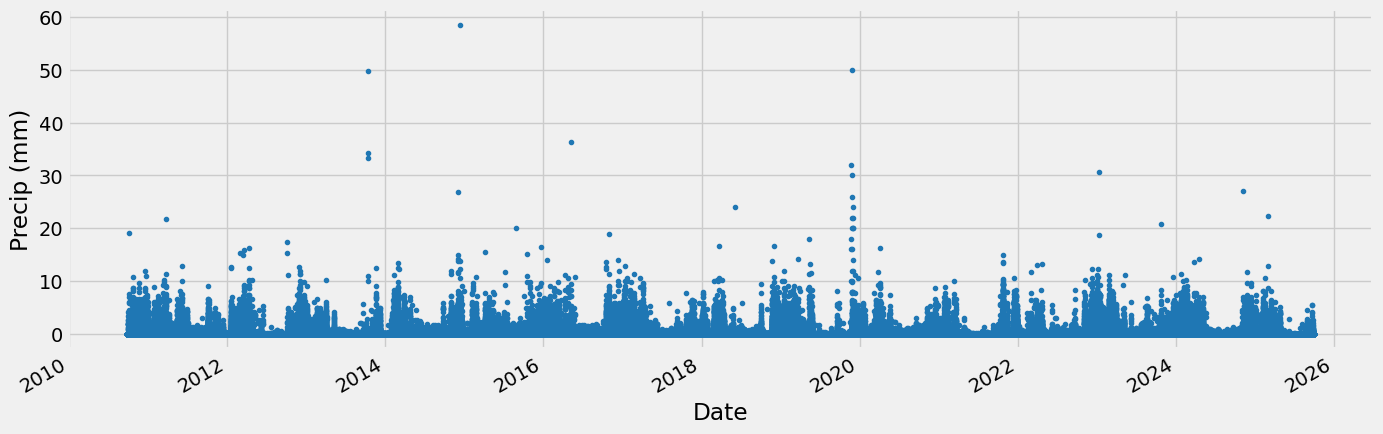

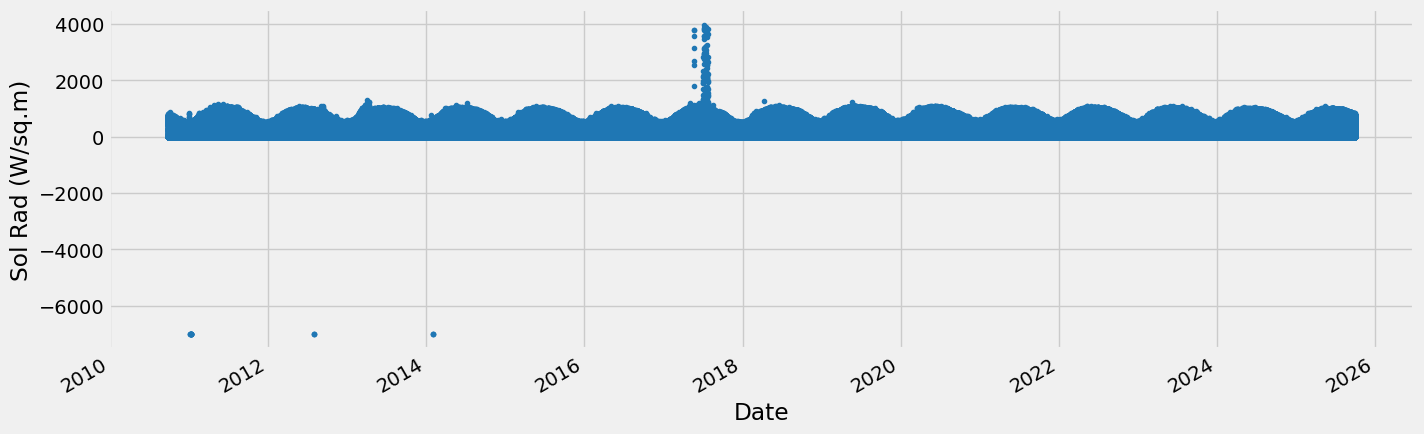

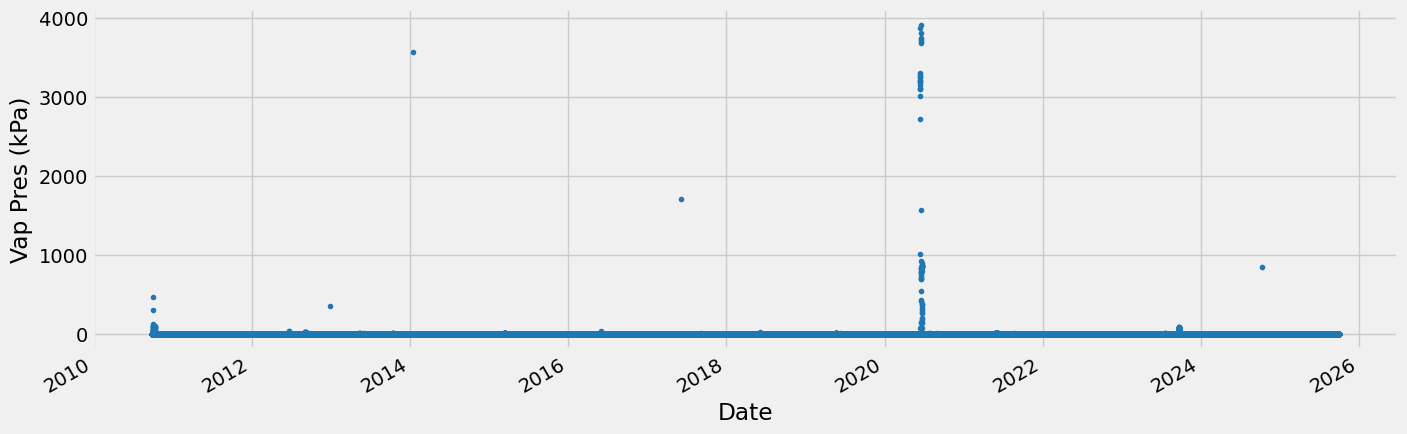

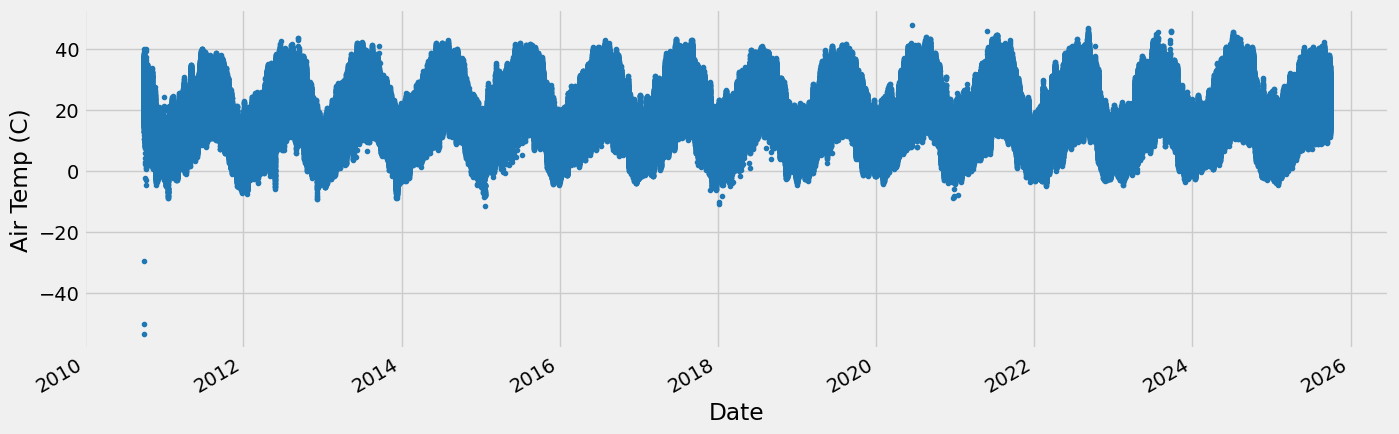

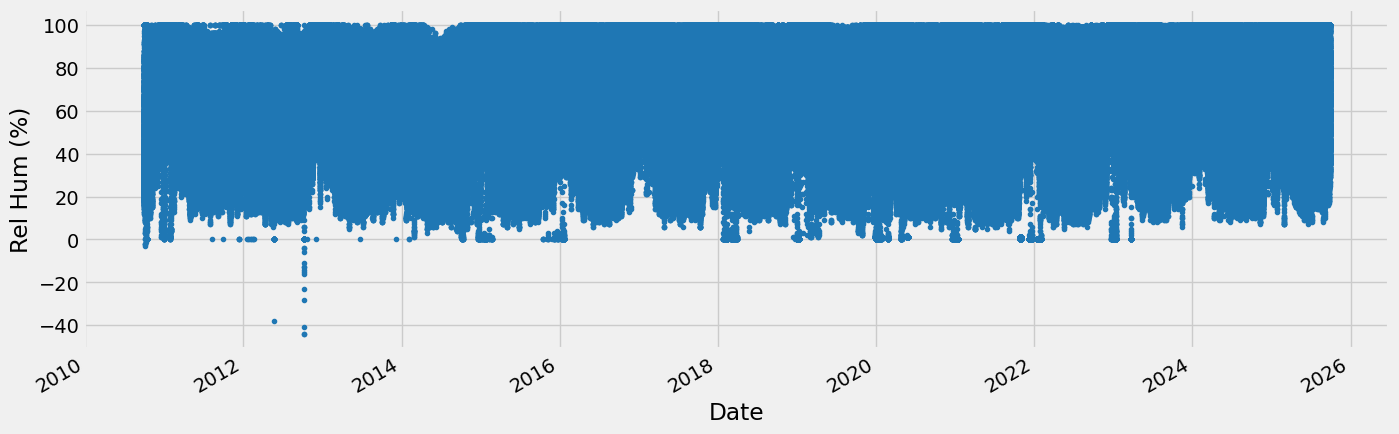

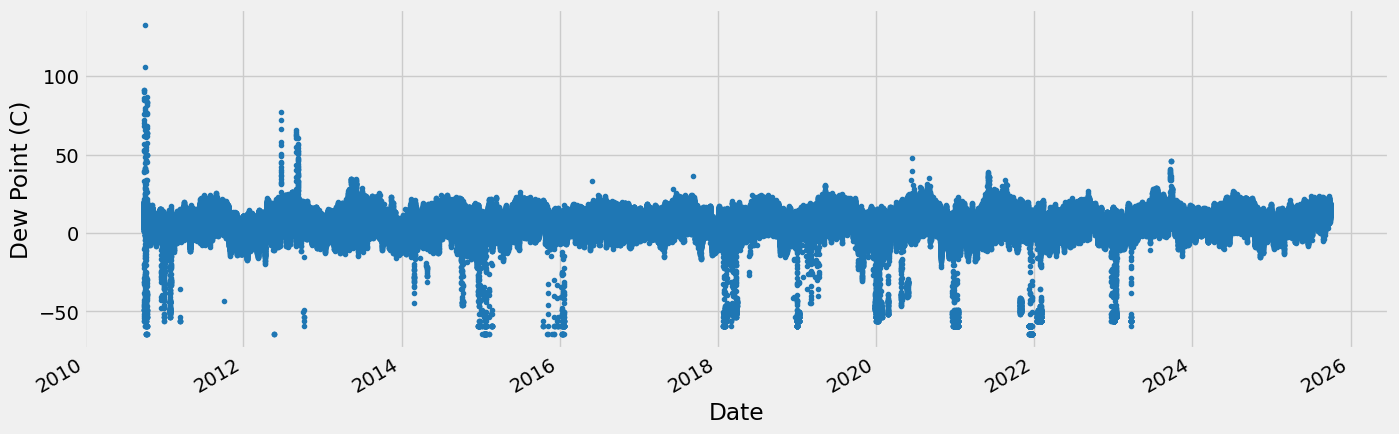

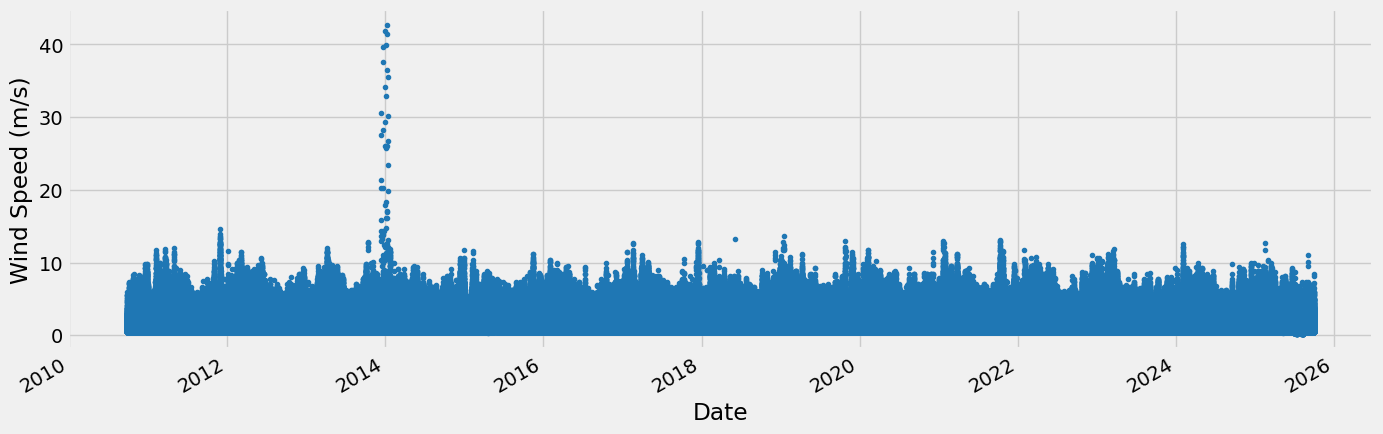

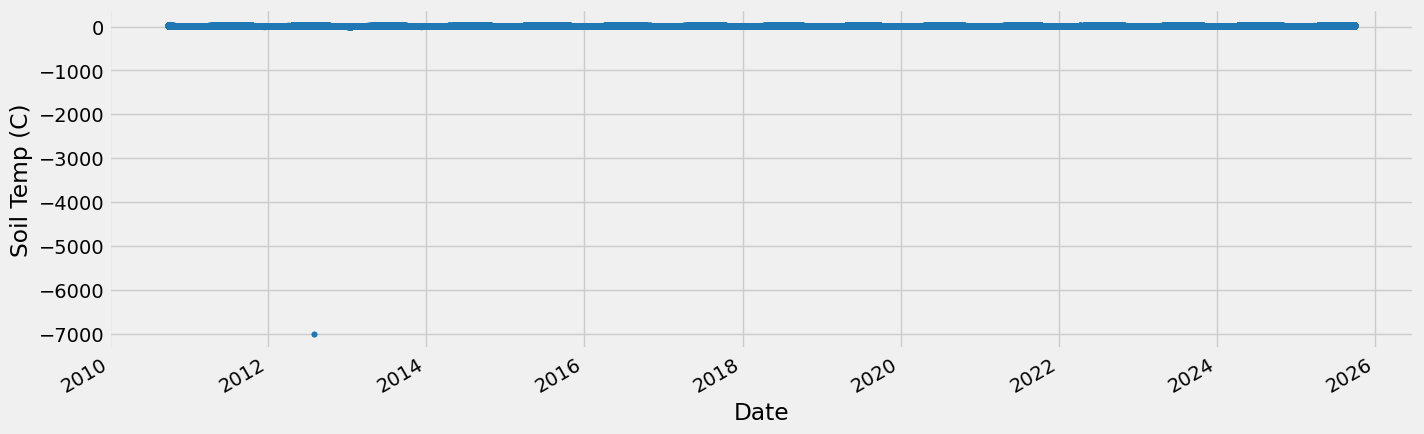

In [12]:
weather_cols = ["ETo (mm)", "Precip (mm)", "Sol Rad (W/sq.m)", "Vap Pres (kPa)","Air Temp (C)", "Rel Hum (%)", "Dew Point (C)", "Wind Speed (m/s)",
                "Soil Temp (C)"] #We leave out wind direction as this will always be a value between 0-360 and, while it might be useful for predicting 
                                 #the distribution does not necessarily give us much information 

dfs = df.set_index("Date")

for col in weather_cols: 
    plt.figure(figsize=(15,5))
    dfs[col].plot(style='.', color = color_pal[0])
    plt.ylabel(col)
    plt.show()

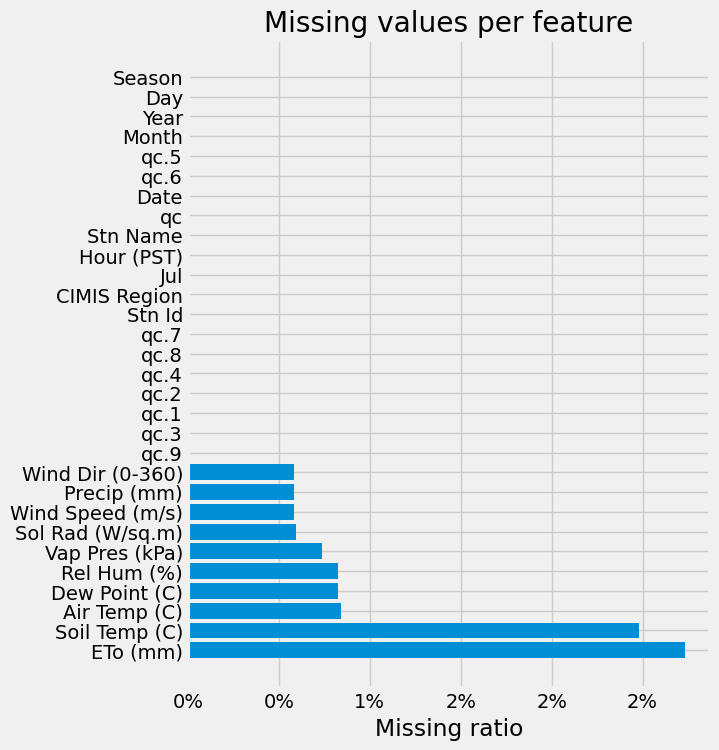

In [13]:
missing = (
    df.isna()
      .sum()
      .rename("null_count")
      .to_frame()
)
missing["null_ratio"] = missing["null_count"] / len(df)

missing = missing.sort_values("null_ratio", ascending=False)

plt.figure(figsize=(6, 8))
plt.barh(missing.index, missing["null_ratio"])
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlabel("Missing ratio")
plt.title("Missing values per feature")
plt.show()

We can see above that most of our weather features have missing values. Overall quantity of missing values is fairly low (Maximum of around 2.5%), and missing values occurred only in our weather measurements and our metadata fields (station id, date, QC flags, etc.) are complete. Going forward, we will now simply impute the values instead of dropping rows with missing values since missingness is feature-specific and not uniform. 

## Time Series Forecasting

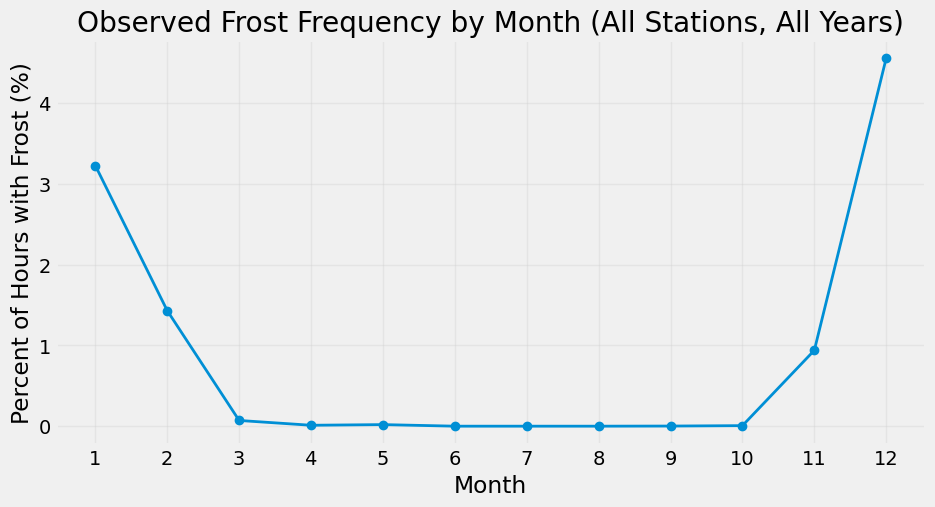

In [23]:
# Build timestamp
df["Date"] = pd.to_datetime(df["Date"])
df["hour"] = (df["Hour (PST)"] // 100).astype(int)
df["timestamp"] = df["Date"] + pd.to_timedelta(df["hour"], unit='h')

# Frost event
df["frost"] = (df["Air Temp (C)"] < 0).astype(int)

# Extract month
df["month"] = df["timestamp"].dt.month

# Monthly frost frequency (percentage of hours that are frost)
monthly = df.groupby("month")["frost"].mean() * 100

plt.figure(figsize=(10,5))
plt.plot(monthly.index, monthly.values, marker='o', linewidth=2)

plt.title("Observed Frost Frequency by Month (All Stations, All Years)")
plt.xlabel("Month")
plt.ylabel("Percent of Hours with Frost (%)")
plt.xticks(range(1,13))
plt.grid(alpha=0.3)
plt.show()

This figure shows the observed frost climatology across all CIMIS stations and all years in the dataset. For each month, we took every hourly observation, labeled hours below 0°C as frost, and computed the percentage of hours with frost. The line clearly shows that frost is heavily concentrated in the winter months, roughly November through February—and is almost nonexistent in summer, which validates that our model is operating in a strongly seasonal frost regime.

Using feature columns: ['ETo (mm)', 'Precip (mm)', 'Sol Rad (W/sq.m)', 'Vap Pres (kPa)', 'Air Temp (C)', 'Rel Hum (%)', 'Dew Point (C)', 'Wind Speed (m/s)', 'Soil Temp (C)', 'month', 'hour']


C:\Users\tyler\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:09:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


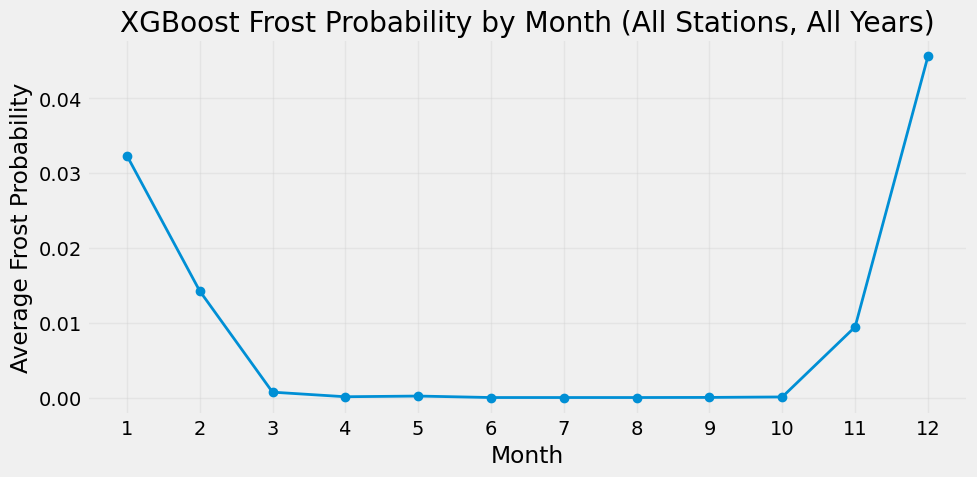

In [ ]:

time_feats = ["month", "hour"]
feature_cols = weather_cols + time_feats

X = df[feature_cols]
y = df["frost"]

# Fit XGBoost classifier

model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    use_label_encoder=False
)

model.fit(X, y)

# Predict frost probability for every hour
df["frost_prob"] = model.predict_proba(X)[:, 1]


# Average frost probability by month (all stations, all years)

monthly_frost = df.groupby("month")["frost_prob"].mean()

plt.figure(figsize=(10, 5))
plt.plot(monthly_frost.index, monthly_frost.values, marker="o", linewidth=2)
plt.title("XGBoost Frost Probability by Month (All Stations, All Years)")
plt.xlabel("Month")
plt.ylabel("Average Frost Probability")
plt.xticks(range(1, 13))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


We took the full CIMIS dataset, defined frost as any hour below 0°C, and trained an XGBoost classifier to predict the probability of frost from weather variables and time-of-year features. Then, for every hour in the dataset, we computed the model’s frost probability and averaged those probabilities by month across all stations and all years. The resulting curve shows the climatological pattern of frost risk: it’s highest in winter, almost zero in summer, and transitions in spring and fall.

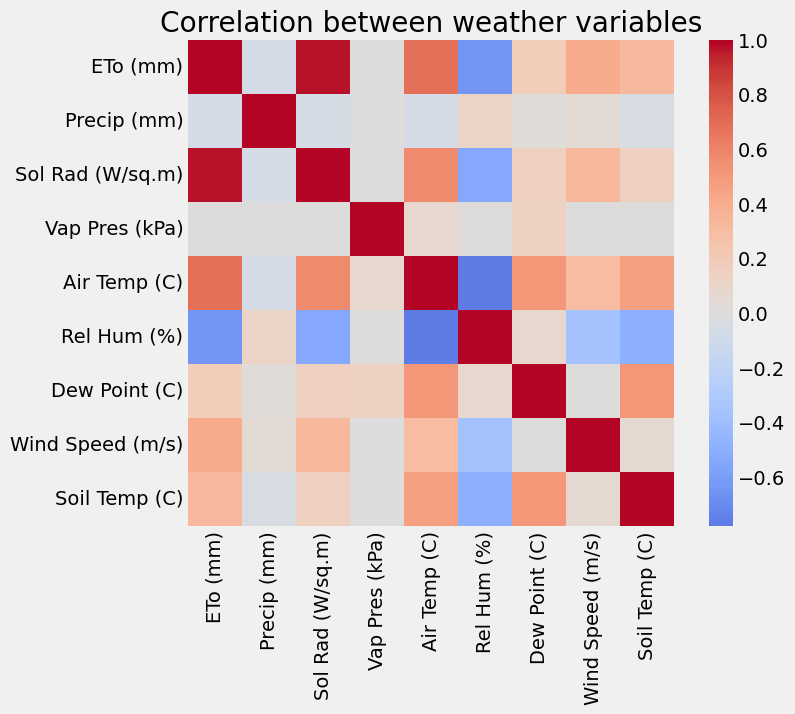

In [12]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[weather_cols].corr(), cmap="coolwarm", center=0, square=True)
plt.title("Correlation between weather variables")
plt.show()

This heatmap displays which of our weather predictors are correlated. In this specific heatmap, the more red the intersection squares are, the more correlated the predictors. The most noticeably correlated two predictors are ETo (reference evapotranspiration) and Solar radiation, which is what we would expect. ETo measures how much water a healthy, well-watered grass plant would lose through evaporation (water turning into vapor from the soil surface) and Transpiration (water released from plant leaves). We would expect this to be correlated with solar radiation as this radiation provides the plants with the necessary energy for evaporation 

In [13]:
df = df.sort_values(["Stn Id", "Date", "Hour (PST)"]).reset_index(drop=True)

df["frost_event"] = (df["Air Temp (C)"] < 0).astype(int)

for h in [3, 6, 12, 24]:

    df[f"temp_{h}h_ahead"] = (
        df.groupby("Stn Id")["Air Temp (C)"].shift(-h)
    )

    df[f"frost_{h}h_ahead"] = (
        df[f"temp_{h}h_ahead"] < 0
    ).astype(int)

Since the challenge asks us to predict frost risk (T < 0 °C) and expected temperature at 3 h, 6 h, 12 h, 24 h horizons, we will create columns for these.

"In addition, the dew point temperature is often used to predict the next morning’s minimum temperature.  Consequently, it is extremely important for freeze protection of crops."

https://biomet.ucdavis.edu/doc/Principles_of_Frost_Protection%E2%80%93UCDavis_Biometeorology_Group.pdf on Page 7

In [14]:
for h in [1, 3, 6, 12]:

    grp = df.groupby("Stn Id")  # group once for efficiency

    # Temperature lag and change
    lag_temp = grp["Air Temp (C)"].shift(h)
    df[f"temp_lag_{h}h"] = lag_temp
    df[f"temp_change_{h}h"] = df["Air Temp (C)"] - lag_temp

    # Dewpoint depression lag
    df[f"dewpoint_dep_{h}h"] = (
        grp["Air Temp (C)"].shift(h) - grp["Dew Point (C)"].shift(h)
    )

    # Humidity lag
    df[f"hum_lag_{h}h"] = grp["Rel Hum (%)"].shift(h)

    # Wind lag
    df[f"wind_lag_{h}h"] = grp["Wind Speed (m/s)"].shift(h)

"The dew point is important in meteorology because it is directly related to the amount of water vapor in the air and it can be used to determine other variables (e.g., vapor pressure, relative humidity, wet bulb temperature, and vapor pressure deficit) that are often used in agriculture." Page 7 

Dewpoint depression is simply measuring the difference between the air temperature and dew point temperature. A small dewpoint depression means that the air is close to saturation and when the dewpoint is high realtive to the air temperature, the air cannot hold much more moisture. This allows for rapid radiative cooling due to the difference in temperature.

This video exlains the mechanism a little bit: https://youtu.be/6buQuGG53gs?si=GKY9xD4dmnzo_kOB&t=11.

Temperature Change / Cooling Rate (Air Temp – Air Temp.shift(3) : 
This is simply how fast the surface layer is cooling during the evening. This is important since rapid cooling after sunset is a strong precursor to frost formation.

Calm-Wind Indicator (Wind Speed < 1 m/s) :
This is an important predictor because calm winds allow cold, dense air to settle near the surface. Most radiation frosts occur under clear, calm conditions because minimal turbulence prevents mixing with warmer air aloft. When wind speed drops below 1 m/s, surface cooling accelerates and frost risk increases significantly.

Vapor Pressure Deficit (VPD) : Represents atmospheric dryness. Low VPD indicates moist air and slower cooling, while high VPD indicates dry air and faster radiational cooling. Sudden decreases in VPD often precede frost formation. Is calculated using "Saturation vapor pressure" (es), which represents the maximum moisture the air could hold at a given temperature. Subtracting the actual vapor pressure gives VPD, which measures atmospheric dryness. Formula used below can be found at : https://wikifire.wsl.ch/tiki-index99b6.html?page=Vapor+pressure+deficit&utm_source=chatgpt.com 

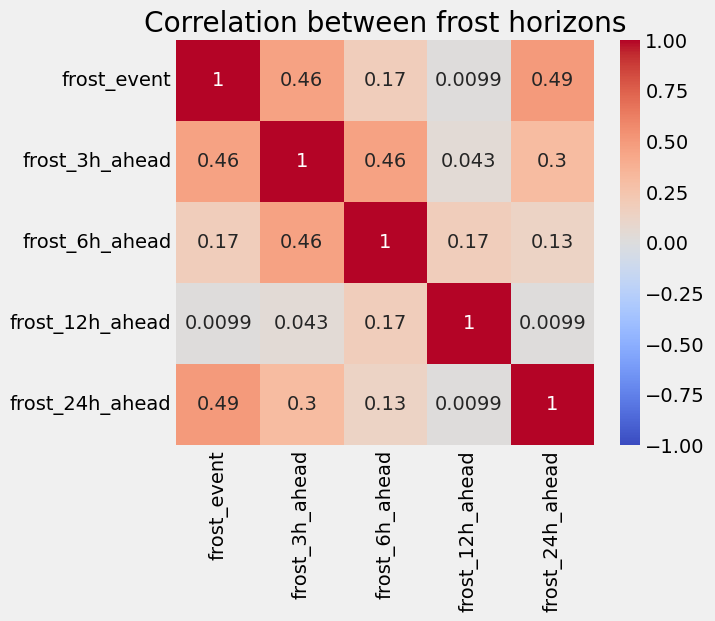

In [15]:
target_cols = [
    "frost_event", "frost_3h_ahead", "frost_6h_ahead",
    "frost_12h_ahead", "frost_24h_ahead"
]

plt.figure(figsize=(6, 5))
sns.heatmap(df[target_cols].corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation between frost horizons")
plt.show()


In the above figure, we can see that short-term (3 hour) frost is moderately correlated with the current conditions and 12 hour frost is essentially independent. 

In [16]:
df["dewpoint_dep"] = df["Air Temp (C)"] - df["Dew Point (C)"]
df["temp_rate"] = df["Air Temp (C)"] - df["Air Temp (C)"].shift(3)
df["calm_wind"] = (df["Wind Speed (m/s)"] < 1).astype(int)
es = 0.6108 * np.exp((17.27 * df["Air Temp (C)"]) / (df["Air Temp (C)"] + 237.3))
df["vpd"] = es - df["Vap Pres (kPa)"]

We encode the month using sine and cosine so the model understands that months are cyclical. Without this transformation, the model would treat December (12) and January (1) as being far apart, even though they are consecutive and belong to the same season. The sine/cosine encoding fixes this by placing all months on a circular scale, preserving their seasonal relationships.

In [17]:
df["is_night"] = (df["Sol Rad (W/sq.m)"] < 10).astype(int)

df["month_sin"] = np.sin(2 * np.pi * df["Month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["Month"] / 12)

We will now apply the same logic to the direction, because right now the wind direction being 359° and 1° are being perceived to be much different than we know them to be in reality.

In [18]:
rad = np.deg2rad(df["Wind Dir (0-360)"])
df["wind_u"] = df["Wind Speed (m/s)"] * np.cos(rad)  # east–west
df["wind_v"] = df["Wind Speed (m/s)"] * np.sin(rad)  # north–south

In [19]:
station_meta = df[["Stn Id","Stn Name","CIMIS Region"]].drop_duplicates().reset_index(drop=True)

df = df.merge(station_meta, on=["Stn Id","Stn Name","CIMIS Region"], how="left")

In [20]:
df.head()

,Stn Id,Stn Name,CIMIS Region,Date,Hour (PST),Jul,ETo (mm),qc,Precip (mm),qc.1,...,wind_lag_12h,dewpoint_dep,temp_rate,calm_wind,vpd,is_night,month_sin,month_cos,wind_u,wind_v
0,2,FivePoints,San Joaquin Valley,2010-09-28,100,271,0.04,,0.0,,...,NaN,12.9,NaN,0,1.396810,1,-1.0,-1.836970e-16,-0.845049,1.589306
1,2,FivePoints,San Joaquin Valley,2010-09-28,200,271,0.03,,0.0,,...,NaN,12.9,NaN,0,1.338281,1,-1.0,-1.836970e-16,-1.010290,0.818117
2,2,FivePoints,San Joaquin Valley,2010-09-28,300,271,0.03,,0.0,,...,NaN,11.3,NaN,0,1.129777,1,-1.0,-1.836970e-16,-1.477212,-0.260472
3,2,FivePoints,San Joaquin Valley,2010-09-28,400,271,0.03,,0.0,,...,NaN,11.3,-2.4,0,1.063989,1,-1.0,-1.836970e-16,-1.409539,-0.513030
4,2,FivePoints,San Joaquin Valley,2010-09-28,500,271,0.02,,0.0,,...,NaN,10.8,-2.6,0,0.987397,1,-1.0,-1.836970e-16,-1.017658,-0.635903


We benchmark all models against a naive persistence predictor, which simply assumes that the current temperature and frost status remain unchanged at future horizons. This baseline sets the minimum performance that a forecasting model must beat.

In [21]:
naive_results = {}

for h in [3, 6, 12, 24]:
    frost_target = f"frost_{h}h_ahead"
    temp_target  = f"temp_{h}h_ahead"

    # Ground truth
    y_frost = df[frost_target]
    y_temp  = df[temp_target]

    mask = (
        ~y_temp.isna()
        & ~y_frost.isna()
        & ~df["Air Temp (C)"].isna()
        & ~df["frost_event"].isna()
    )

    temp_now  = df.loc[mask, "Air Temp (C)"].astype(float)   
    frost_now = df.loc[mask, "frost_event"].astype(float)    

    temp_future  = y_temp[mask].astype(float)                
    frost_future = y_frost[mask].astype(float)               

    naive_rmse  = np.sqrt(mean_squared_error(temp_future, temp_now))
    naive_brier = np.mean((frost_now - frost_future)**2)

    naive_results[h] = {
        "rmse": naive_rmse,
        "brier": naive_brier
    }

    print(f"Naive Brier={naive_brier:.4f} | Horizon {h}h → Naive RMSE={naive_rmse:.3f} |")



Naive Brier=0.0092 | Horizon 3h → Naive RMSE=4.312 |
Naive Brier=0.0142 | Horizon 6h → Naive RMSE=7.367 |
Naive Brier=0.0170 | Horizon 12h → Naive RMSE=10.001 |
Naive Brier=0.0086 | Horizon 24h → Naive RMSE=2.724 |


In [22]:
## def AccuracyTestFrost(y, briers):
##    mean_frost = y.mean()
##    baseline_brier = np.mean((mean_frost - y)**2)
##    print("Frost rate:", y.mean())
##    print("Baseline Brier:", baseline_brier)
##    print("Model mean Brier:", np.mean(briers))
##    print("Improvement:", 1 - np.mean(briers)/baseline_brier)

## Accuracy_Test(ytr_frost_full, brier_scores)

In [23]:
group_col = "Stn Id"

qc_cols = [c for c in df.columns if str(c).startswith("qc")]

future_cols = [c for c in df.columns
               if re.match(r"^(temp|frost)_\d+h_ahead$", str(c))]

#Basically all the columns we are NEVER going to use as features
base_exclude = set(
    [group_col, "Stn Name", "CIMIS Region", "Date", "Hour (PST)"]
    + qc_cols
    + future_cols        # <- drop ALL future horizon cols
)

num_feats = [c for c in df.columns
             if c not in base_exclude and pd.api.types.is_numeric_dtype(df[c])]

maybe_cat = ["climate_zone"]
cat_feats = [c for c in maybe_cat if c in df.columns]

used_cols = num_feats + cat_feats

transformers = [
    ("num", Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler())
    ]), num_feats)
]
if cat_feats:
    transformers.append(("cat", OneHotEncoder(handle_unknown="ignore"), cat_feats))

pre = ColumnTransformer(transformers, remainder="drop")

X_raw = df[used_cols].copy()

for c in num_feats:
    X_raw[c] = X_raw[c].astype(np.float32)
    
groups = df[group_col]

#gkf = GroupKFold(n_splits=df[group_col].nunique())
gkf = GroupKFold(n_splits=2) #Change later


===== Horizon 3h: Random Forest predicting frost_3h_ahead & temp_3h_ahead =====
Fold 1: RF Brier=0.0043, RF RMSE=1.955
Fold 2: RF Brier=0.0039, RF RMSE=2.120
Horizon 3h → RF Brier mean±sd: 0.0041 ± 0.0002, RF Temp RMSE mean±sd: 2.038 ± 0.083


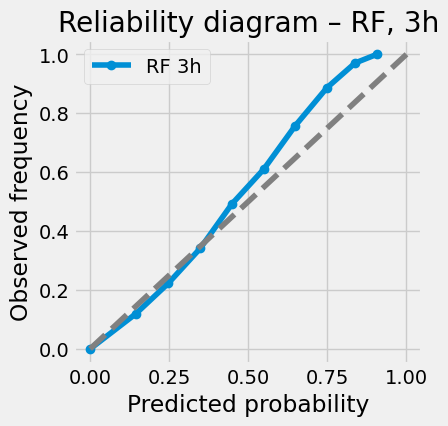

Horizon 3h RF  → ROC-AUC=0.996, PR-AUC=0.733, ECE=0.0014

===== Horizon 6h: Random Forest predicting frost_6h_ahead & temp_6h_ahead =====
Fold 1: RF Brier=0.0054, RF RMSE=2.810
Fold 2: RF Brier=0.0048, RF RMSE=3.039
Horizon 6h → RF Brier mean±sd: 0.0051 ± 0.0003, RF Temp RMSE mean±sd: 2.925 ± 0.115


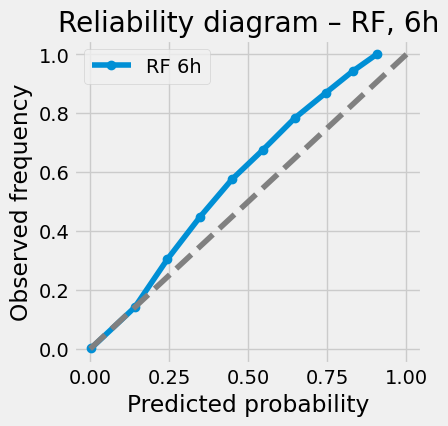

Horizon 6h RF  → ROC-AUC=0.992, PR-AUC=0.601, ECE=0.0023

===== Horizon 12h: Random Forest predicting frost_12h_ahead & temp_12h_ahead =====
Fold 1: RF Brier=0.0057, RF RMSE=2.459
Fold 2: RF Brier=0.0048, RF RMSE=2.609
Horizon 12h → RF Brier mean±sd: 0.0053 ± 0.0004, RF Temp RMSE mean±sd: 2.534 ± 0.075


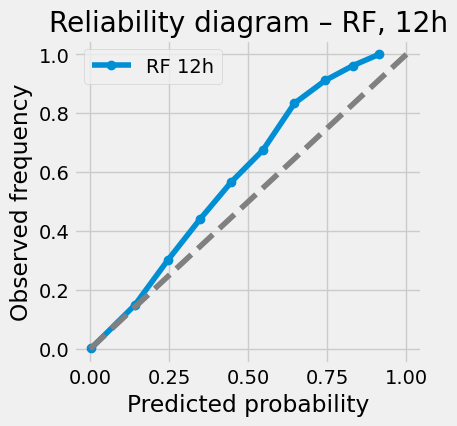

Horizon 12h RF  → ROC-AUC=0.990, PR-AUC=0.588, ECE=0.0026

===== Horizon 24h: Random Forest predicting frost_24h_ahead & temp_24h_ahead =====
Fold 1: RF Brier=0.0059, RF RMSE=2.472
Fold 2: RF Brier=0.0051, RF RMSE=2.583
Horizon 24h → RF Brier mean±sd: 0.0055 ± 0.0004, RF Temp RMSE mean±sd: 2.528 ± 0.056


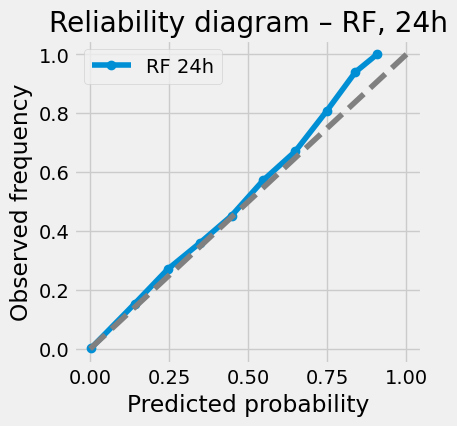

Horizon 24h RF  → ROC-AUC=0.988, PR-AUC=0.536, ECE=0.0011


In [32]:
horizons = [3, 6,12,24]     # change if needed
rf_results = {}

for h in horizons:

    frost_target = f"frost_{h}h_ahead"
    temp_target  = f"temp_{h}h_ahead"

    print(f"\n===== Horizon {h}h: Random Forest predicting {frost_target} & {temp_target} =====")

    y_frost = df[frost_target].astype(int)
    y_temp  = df[temp_target].astype(np.float32)

    # mask valid rows for this horizon
    mask = ~y_temp.isna()
    X_h       = X_raw[mask]
    y_frost_h = y_frost[mask]
    y_temp_h  = y_temp[mask]
    groups_h  = groups[mask]

    brier_scores = []
    rmse_scores  = []

    # For calibration metrics
    all_y_frost = []
    all_p_frost = []

    # === LOSO CV per horizon ===
    for fold, (tr, te) in enumerate(gkf.split(X_h, y_frost_h, groups=groups_h), 1):

        Xtr_raw_full, Xte_raw = X_h.iloc[tr], X_h.iloc[te]
        ytr_frost_full, yte_frost = y_frost_h.iloc[tr], y_frost_h.iloc[te]
        ytr_temp_full,  yte_temp  = y_temp_h.iloc[tr],  y_temp_h.iloc[te]

        # Preprocess
        pre.fit(Xtr_raw_full, ytr_frost_full)
        Xtr = pre.transform(Xtr_raw_full)
        Xte = pre.transform(Xte_raw)

        # =============================
        #   RANDOM FOREST CLASSIFIER
        # =============================
        rf_clf = RandomForestClassifier(
            n_estimators=50,
            max_depth=10,
            min_samples_leaf=100,
            max_features="sqrt",
            random_state=42,
            n_jobs=-1
        )

        rf_clf.fit(Xtr, ytr_frost_full)
        p_frost = rf_clf.predict_proba(Xte)[:, 1]

        brier = brier_score_loss(yte_frost, p_frost)
        brier_scores.append(brier)

        # Save predictions for calibration
        all_y_frost.append(yte_frost.values)
        all_p_frost.append(p_frost)

        # =============================
        #   RANDOM FOREST REGRESSOR
        # =============================
        rf_reg = RandomForestRegressor(
            n_estimators=50,
            max_depth=10,
            min_samples_leaf=100,
            max_features="sqrt",
            random_state=42,
            n_jobs=-1
        )

        rf_reg.fit(Xtr, ytr_temp_full)
        t_pred = rf_reg.predict(Xte)

        rmse = np.sqrt(mean_squared_error(yte_temp, t_pred))
        rmse_scores.append(rmse)

        print(f"Fold {fold}: RF Brier={brier:.4f}, RF RMSE={rmse:.3f}")

    # =============================
    #   AGGREGATED METRICS
    # =============================
    mean_brier = np.mean(brier_scores)
    std_brier  = np.std(brier_scores)
    mean_rmse  = np.mean(rmse_scores)
    std_rmse   = np.std(rmse_scores)

    print(
        f"Horizon {h}h → RF Brier mean±sd: {mean_brier:.4f} ± {std_brier:.4f}, "
        f"RF Temp RMSE mean±sd: {mean_rmse:.3f} ± {std_rmse:.3f}"
    )

    rf_results[h] = {
        "brier_mean": mean_brier,
        "brier_std":  std_brier,
        "rmse_mean":  mean_rmse,
        "rmse_std":   std_rmse,
    }

    # =============================
    #   CALIBRATION + ROC-AUC + PR-AUC
    # =============================
    all_y_frost = np.concatenate(all_y_frost)
    all_p_frost = np.concatenate(all_p_frost)

    prob_true, prob_pred = calibration_curve(all_y_frost, all_p_frost,
                                             n_bins=10, strategy="uniform")

    plt.figure(figsize=(4, 4))
    plt.plot(prob_pred, prob_true, marker='o', label=f'RF {h}h')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlabel("Predicted probability")
    plt.ylabel("Observed frequency")
    plt.title(f"Reliability diagram – RF, {h}h")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ECE
    hist = np.histogram(all_p_frost, bins=10, range=(0, 1))[0]
    ece = np.average(np.abs(prob_true - prob_pred), weights=hist)

    roc = roc_auc_score(all_y_frost, all_p_frost)
    pr  = average_precision_score(all_y_frost, all_p_frost)

    print(f"Horizon {h}h RF  → ROC-AUC={roc:.3f}, PR-AUC={pr:.3f}, ECE={ece:.4f}")


===== Horizon 3h: XGB predicting frost_3h_ahead & temp_3h_ahead =====
Fold 1: XGB Brier=0.0042, XGB RMSE=1.898
Fold 2: XGB Brier=0.0039, XGB RMSE=2.074
Horizon 3h → XGB Brier mean±sd: 0.0041 ± 0.0001, XGB Temp RMSE mean±sd: 1.986 ± 0.088


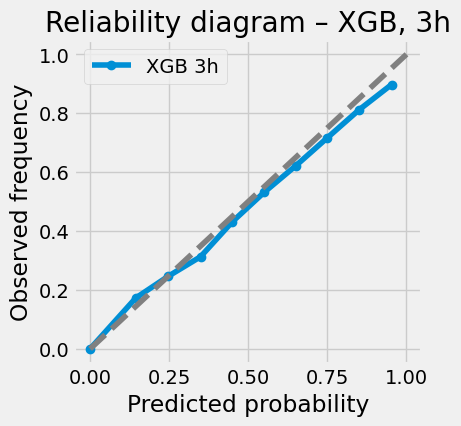

Horizon 3h XGB → ROC-AUC=0.996, PR-AUC=0.712, ECE=0.0007

===== Horizon 6h: XGB predicting frost_6h_ahead & temp_6h_ahead =====
Fold 1: XGB Brier=0.0054, XGB RMSE=2.756
Fold 2: XGB Brier=0.0051, XGB RMSE=3.000
Horizon 6h → XGB Brier mean±sd: 0.0053 ± 0.0002, XGB Temp RMSE mean±sd: 2.878 ± 0.122


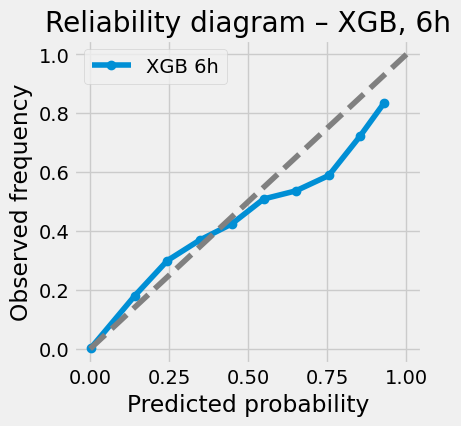

Horizon 6h XGB → ROC-AUC=0.991, PR-AUC=0.571, ECE=0.0013

===== Horizon 12h: XGB predicting frost_12h_ahead & temp_12h_ahead =====
Fold 1: XGB Brier=0.0056, XGB RMSE=2.352
Fold 2: XGB Brier=0.0048, XGB RMSE=2.510
Horizon 12h → XGB Brier mean±sd: 0.0052 ± 0.0004, XGB Temp RMSE mean±sd: 2.431 ± 0.079


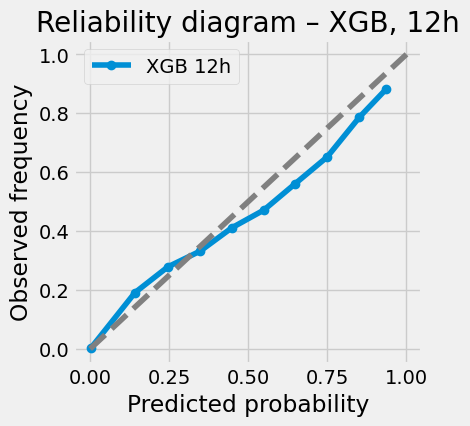

Horizon 12h XGB → ROC-AUC=0.991, PR-AUC=0.584, ECE=0.0010

===== Horizon 24h: XGB predicting frost_24h_ahead & temp_24h_ahead =====
Fold 1: XGB Brier=0.0058, XGB RMSE=2.432
Fold 2: XGB Brier=0.0055, XGB RMSE=2.555
Horizon 24h → XGB Brier mean±sd: 0.0056 ± 0.0001, XGB Temp RMSE mean±sd: 2.493 ± 0.062


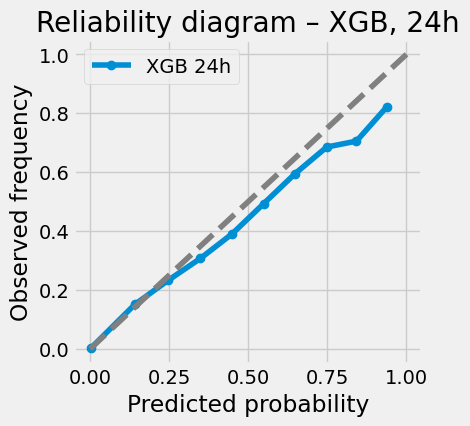

Horizon 24h XGB → ROC-AUC=0.988, PR-AUC=0.505, ECE=0.0007


In [31]:
xgb_results = {}
horizons = [3,6,12,24] # Change soon

for h in horizons:
    frost_target = f"frost_{h}h_ahead"
    temp_target  = f"temp_{h}h_ahead"

    print(f"\n===== Horizon {h}h: XGB predicting {frost_target} & {temp_target} =====")

    y_frost = df[frost_target].astype(int)
    y_temp  = df[temp_target].astype(np.float32)

    mask = ~y_temp.isna()
    X_h       = X_raw[mask]
    y_frost_h = y_frost[mask]
    y_temp_h  = y_temp[mask]
    groups_h  = groups[mask]

    brier_scores = []
    rmse_scores  = []

    all_y_frost = []
    all_p_frost = []

    
    for fold, (tr, te) in enumerate(gkf.split(X_h, y_frost_h, groups=groups_h), 1):
        Xtr_raw_full, Xte_raw = X_h.iloc[tr], X_h.iloc[te]
        ytr_frost_full, yte_frost = y_frost_h.iloc[tr], y_frost_h.iloc[te]
        ytr_temp_full,  yte_temp  = y_temp_h.iloc[tr],  y_temp_h.iloc[te]

        pre.fit(Xtr_raw_full, ytr_frost_full)
        Xtr = pre.transform(Xtr_raw_full)
        Xte = pre.transform(Xte_raw)

        clf = XGBClassifier(
            n_estimators=120,
            learning_rate=0.12,
            max_depth=3,
            subsample=0.9,
            colsample_bytree=0.9,
            eval_metric="logloss",
            n_jobs=-1,
            tree_method="hist",
            verbosity=0,
        )
        clf.fit(Xtr, ytr_frost_full)
        p_frost = clf.predict_proba(Xte)[:, 1]

        brier = brier_score_loss(yte_frost, p_frost)
        brier_scores.append(brier)

        all_y_frost.append(yte_frost.values)
        all_p_frost.append(p_frost)
        
        reg = XGBRegressor(
            n_estimators=120,
            learning_rate=0.12,
            max_depth=3,
            subsample=0.9,
            colsample_bytree=0.9,
            n_jobs=-1,
            tree_method="hist",
            verbosity=0,
        )
        reg.fit(Xtr, ytr_temp_full)
        t_pred = reg.predict(Xte)

        rmse = np.sqrt(mean_squared_error(yte_temp, t_pred))
        rmse_scores.append(rmse)

        print(f"Fold {fold}: XGB Brier={brier:.4f}, XGB RMSE={rmse:.3f}")

    print(
        f"Horizon {h}h → XGB Brier mean±sd: {np.mean(brier_scores):.4f} ± {np.std(brier_scores):.4f}, "
        f"XGB Temp RMSE mean±sd: {np.mean(rmse_scores):.3f} ± {np.std(rmse_scores):.3f}"
    )

    xgb_results[h] = {
        "brier_mean": np.mean(brier_scores),
        "brier_std":  np.std(brier_scores),
        "rmse_mean":  np.mean(rmse_scores),
        "rmse_std":   np.std(rmse_scores),
    }

    all_y_frost = np.concatenate(all_y_frost)
    all_p_frost = np.concatenate(all_p_frost)

    prob_true, prob_pred = calibration_curve(all_y_frost, all_p_frost,
                                             n_bins=10, strategy="uniform")

    plt.figure(figsize=(4, 4))
    plt.plot(prob_pred, prob_true, marker='o', label=f'XGB {h}h')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlabel("Predicted probability")
    plt.ylabel("Observed frequency")
    plt.title(f"Reliability diagram – XGB, {h}h")
    plt.legend()
    plt.grid(True)
    plt.show()

    hist = np.histogram(all_p_frost, bins=10, range=(0, 1))[0]
    ece = np.average(np.abs(prob_true - prob_pred), weights=hist)

    roc = roc_auc_score(all_y_frost, all_p_frost)
    pr  = average_precision_score(all_y_frost, all_p_frost)

    print(f"Horizon {h}h XGB → ROC-AUC={roc:.3f}, PR-AUC={pr:.3f}, ECE={ece:.4f}")

The ROC-AUC being 0.9866 doesn't have anything to do with the probability, but in this case it means that model's ability to rank frost vs. non-frost cases is very strong. This seems pretty likely since frost has a very distinct signature that we have captured (temperature change dropping sharply, dewpoint depression collapses, wind is near-zero, radiation being low, it being nighttime, etc)."

Here we will look at the feature importances from the trained XGBoost model using the gain metric. This reveals which predictors contribute most to reducing error across the decision trees, and therefore which variables the model considers most informative for frost forecasting.